## Setup

In [52]:
import pandas as pd

from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [53]:
baseball = pd.read_csv('data/baseball.csv')

X = baseball.drop(['Salary'], axis = 1)
y = baseball['Salary']

In [54]:
cat_columns = ['Tm', 'Lg', 'Acquired', 'Bat']
num_columns = [col for col in X.columns if col not in cat_columns + ['Pos_C', 'Pos_1B', 'Pos_2B', 'Pos_3B', 'Pos_SS', 'Pos_OF']]

cat_transformer = Pipeline(
    steps = [
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

num_transformer = Pipeline(
    steps = [
        ('scale', StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ('cont', num_transformer, num_columns),
        ('cat', cat_transformer, cat_columns)
    ], remainder = 'passthrough'
)

X_transform = preprocessor.fit_transform(X)

selected_features = np.concatenate([
    np.array(num_columns),
    np.array(preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(cat_columns)),
    np.array(['Pos_C', 'Pos_1B', 'Pos_2B', 'Pos_3B', 'Pos_SS', 'Pos_OF'])
])


## EDA

In [55]:
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [56]:
# sns.pairplot(baseball)
kmeans = KMeans(n_clusters = 4, n_init = 'auto')
kmeans.fit(X_transform)

baseball['cluster'] = kmeans.labels_

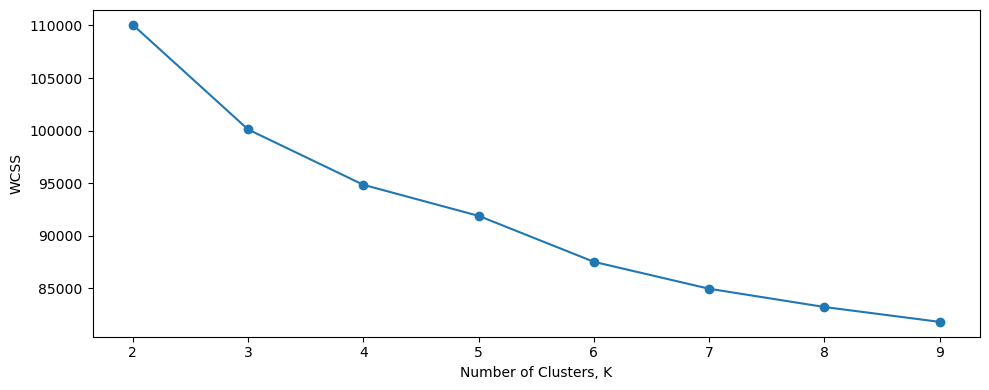

In [57]:
kmeans_per_k = [KMeans(n_clusters=k, n_init='auto', random_state=621).fit(X_transform)
                for k in range(2, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(10,4))
plt.plot(range(2, 10),inertias,marker="o")
plt.xlabel('Number of Clusters, K')
plt.ylabel('WCSS')
plt.tight_layout()
plt.savefig('images/WCSS.png')

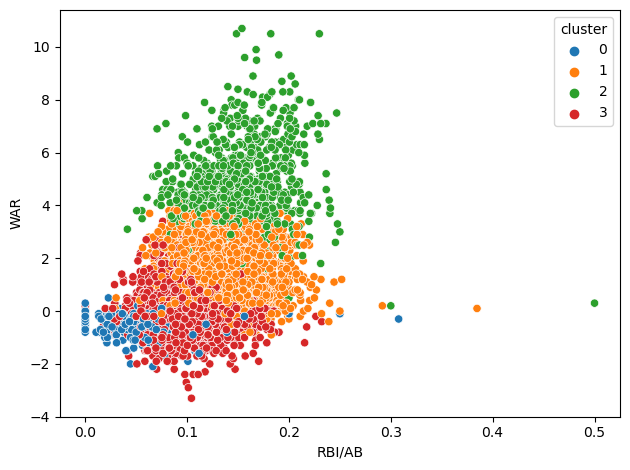

In [58]:
sns.scatterplot(baseball, x = 'RBI/AB', y = 'WAR', hue = 'cluster', palette = 'tab10')
plt.tight_layout()
plt.savefig('images/WAR_RBI.png')

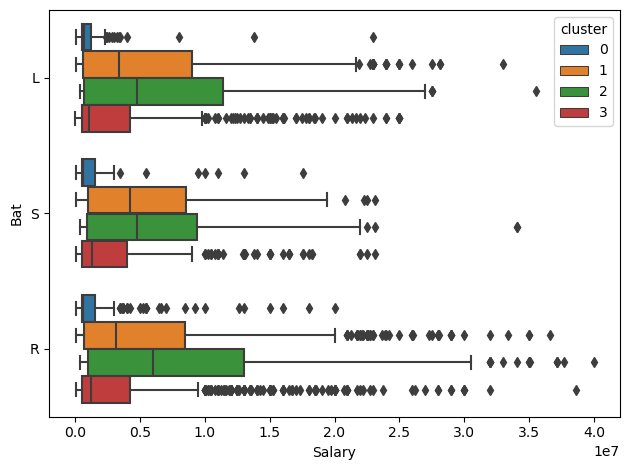

In [59]:
sns.boxplot(baseball, y = 'Bat', x = 'Salary', hue = 'cluster')
plt.tight_layout()
plt.savefig('images/bat_box.png')

<Axes: xlabel='Salary', ylabel='Acquired'>

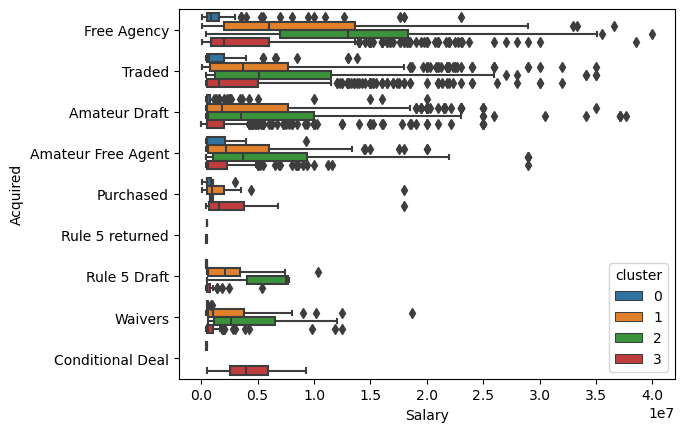

In [60]:
sns.boxplot(baseball, y = 'Acquired', x = 'Salary', hue = 'cluster')

In [61]:
# cluster 0
cluster_0 = baseball[baseball['cluster'] == 0]

# cluster 1
cluster_1 = baseball[baseball['cluster'] == 1]

# cluster 2
cluster_2 = baseball[baseball['cluster'] == 2]

# cluster 3
cluster_3 = baseball[baseball['cluster'] == 3]

print('CLUSTER 0')
print(cluster_0['Salary'].describe())
print('CLUSTER 1')
print(cluster_1['Salary'].describe())
print('CLUSTER 2')
print(cluster_2['Salary'].describe())
print('CLUSTER 3')
print(cluster_3['Salary'].describe())

CLUSTER 0
count    3.620000e+02
mean     1.692284e+06
std      2.980345e+06
min      1.000000e+05
25%      5.095250e+05
50%      6.425000e+05
75%      1.400000e+06
max      2.300000e+07
Name: Salary, dtype: float64
CLUSTER 1
count    1.981000e+03
mean     5.911376e+06
std      6.524643e+06
min      1.000000e+05
25%      7.200000e+05
50%      3.335000e+06
75%      8.500000e+06
max      3.657143e+07
Name: Salary, dtype: float64
CLUSTER 2
count    7.980000e+02
mean     7.947219e+06
std      8.188759e+06
min      4.000000e+05
25%      7.483200e+05
50%      5.500000e+06
75%      1.227880e+07
max      4.000000e+07
Name: Salary, dtype: float64
CLUSTER 3
count    1.920000e+03
mean     3.518415e+06
std      5.069008e+06
min      1.000000e+00
25%      5.293740e+05
50%      1.250000e+06
75%      4.190625e+06
max      3.857143e+07
Name: Salary, dtype: float64


In [62]:
# baseball[baseball['Salary'] == 1.0]
baseball = baseball.drop(170)
baseball.to_csv('best_model/engineered_data.csv', index = False)

X = baseball.drop(['Salary'], axis = 1)
y = baseball['Salary']

## Train Test Split

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 621)

## Random Forest

In [64]:
from sklearn.ensemble import RandomForestRegressor

In [65]:
rf_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators = 200, min_samples_split = 14))
    ]
)

In [66]:
rf_pipe.fit(X_train, y_train)
rf_train_mse = mean_squared_error(y_train, rf_pipe.predict(X_train))
rf_test_mse = mean_squared_error(y_test, rf_pipe.predict(X_test))
print('Random Forest Metrics:')
print(f'Training RMSE: {np.sqrt(rf_train_mse)}')
print(f'Test RMSE: {np.sqrt(rf_test_mse)}')

Random Forest Metrics:
Training RMSE: 3144812.88784123
Test RMSE: 5209714.581445615


## XGBoost

In [67]:
from xgboost import XGBRegressor

In [68]:
xg_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(n_estimators = 100, learning_rate = .03, max_depth = 6))
    ]
)

In [69]:
xg_pipe.fit(X_train, y_train)
xg_train_mse = mean_squared_error(y_train, xg_pipe.predict(X_train))
xg_test_mse = mean_squared_error(y_test, xg_pipe.predict(X_test))
print('XGBoost Metrics:')
print(f'Training RMSE: {np.sqrt(xg_train_mse)}')
print(f'Test RMSE: {np.sqrt(xg_test_mse)}')

XGBoost Metrics:
Training RMSE: 3918883.9017461697
Test RMSE: 5113400.5706560025


## Gradient Boosting

In [70]:
from sklearn.ensemble import GradientBoostingRegressor

In [71]:
gb_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(learning_rate = 0.075, n_estimators = 200, max_depth = 4))
    ]
)

In [72]:
gb_pipe.fit(X_train, y_train)
gb_train_mse = mean_squared_error(y_train, gb_pipe.predict(X_train))
gb_test_mse = mean_squared_error(y_test, gb_pipe.predict(X_test))
print('Gradient Boosting Metrics:')
print(f'Training RMSE: {np.sqrt(gb_train_mse)}')
print(f'Test RMSE: {np.sqrt(gb_test_mse)}')

Gradient Boosting Metrics:
Training RMSE: 3559695.529324085
Test RMSE: 4971624.55951392


## ADA Boost

In [73]:
from sklearn.ensemble import AdaBoostRegressor

In [74]:
ada_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', AdaBoostRegressor(n_estimators = 200, learning_rate = 0.01))
    ]
)

In [75]:
ada_pipe.fit(X_train, y_train)
ada_train_mse = mean_squared_error(y_train, ada_pipe.predict(X_train))
ada_test_mse = mean_squared_error(y_test, ada_pipe.predict(X_test))
print('ADABoost Metrics:')
print(f'Training RMSE: {np.sqrt(ada_train_mse)}')
print(f'Test RMSE: {np.sqrt(ada_test_mse)}')

ADABoost Metrics:
Training RMSE: 5682883.819660862
Test RMSE: 5670737.315691486


## KNN

In [76]:
from sklearn.neighbors import KNeighborsRegressor

In [77]:
knn_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', KNeighborsRegressor(n_neighbors = 5, weights = 'uniform'))
    ]
)

In [78]:
knn_pipe.fit(X_train, y_train)
knn_train_mse = mean_squared_error(y_train, knn_pipe.predict(X_train))
knn_test_mse = mean_squared_error(y_test, knn_pipe.predict(X_test))
print('K-Nearest Neighbors Metrics:')
print(f'Training RMSE: {np.sqrt(knn_train_mse)}')
print(f'Test RMSE: {np.sqrt(knn_test_mse)}')

K-Nearest Neighbors Metrics:
Training RMSE: 4443150.809681636
Test RMSE: 5457428.559782702


## ADA Boost PCA

In [79]:
from sklearn.decomposition import PCA

In [80]:
ada_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components = 37)),
        ('model', AdaBoostRegressor(n_estimators = 200, learning_rate = 0.01))
    ]
)

In [81]:
ada_pipe.fit(X_train, y_train)
ada_train_mse = mean_squared_error(y_train, ada_pipe.predict(X_train))
ada_test_mse = mean_squared_error(y_test, ada_pipe.predict(X_test))
print('ADABoost with PCA Metrics:')
print(f'Training RMSE: {np.sqrt(ada_train_mse)}')
print(f'Test RMSE: {np.sqrt(ada_test_mse)}')

ADABoost with PCA Metrics:
Training RMSE: 5631155.23266417
Test RMSE: 5691088.9171543


## KNN with PCA

In [82]:
knn_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components = 63)),
        ('model', KNeighborsRegressor(n_neighbors = 5, weights = 'uniform'))
    ]
)

In [83]:
knn_pipe.fit(X_train, y_train)
knn_train_mse = mean_squared_error(y_train, knn_pipe.predict(X_train))
knn_test_mse = mean_squared_error(y_test, knn_pipe.predict(X_test))
print('K-Nearest Neighbors with PCA Metrics:')
print(f'Training RMSE: {np.sqrt(knn_train_mse)}')
print(f'Test RMSE: {np.sqrt(knn_test_mse)}')

K-Nearest Neighbors with PCA Metrics:
Training RMSE: 4446536.553175446
Test RMSE: 5467877.922752083
